In [40]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import random
import torch
import torch.nn as nn
from torch.autograd import grad

from binarypredictor.net import DerivativeNet

In [2]:
x = torch.arange(1e-10, 1., step=0.01, requires_grad=True)

f = x * torch.log(x) + (1 - x) * torch.log(1 - x)

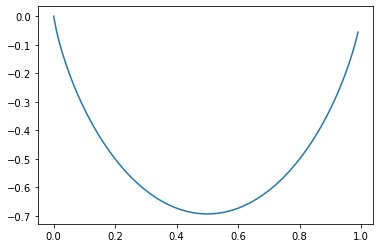

In [3]:
plt.plot(x.detach(), f.detach())

In [4]:
f_ = grad(f, x, grad_outputs=torch.ones_like(x), retain_graph=True)[0]

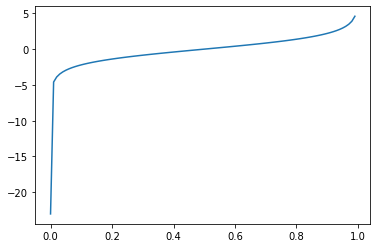

In [5]:
plt.plot(x.detach(), f_.detach())

In [6]:
f_.requires_grad_(True)
a = 0

In [194]:
def generate_A():
    # A_diff
    A_diff = np.random.randint(-2, 5)
    
    # A_sum
    A_sum_base = list(range(-2, 13, 2))
    if A_diff % 2 == 0:
        A_sum_base += list(range(1, 7, 2))
    A_sum = A_sum_base[np.random.randint(len(A_sum_base))]
        
    return A_sum, A_diff

In [271]:
def A(A_sum, A_diff, TM):
    R = 8.314
    
    A_sum *= TM * R
    A_diff *= TM * R
    
    A_1 = (A_sum - A_diff)/2
    A_2 = (A_sum + A_diff)/2
    
    return A_1, A_2

In [272]:
def func(x, T, A, Tm_1, Tm_2, S_1, S_2):
    R = 8.314
    
    return R * T * (x * torch.log(x) + (1 - x) * torch.log(1 - x)) + A * x * (1 - x) + S_1 * (Tm_1 - T) * (1 - x) + S_2 * (Tm_2 - T) * x

In [281]:
def first_derivative(x, T, A, Tm_1, Tm_2, S_1, S_2):
    R = 8.314
    
    return R * T * (torch.log(x) - torch.log(1 - x)) + A * (1 - 2 * x) - S_1 * Tm_1 + S_2 * Tm_2

2484.051569573249 173.63161839092868 1271.9204299158268
722.7760241533778
15022.899662027958 33050.37925646151


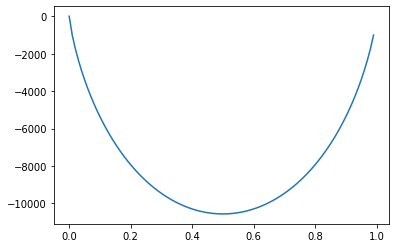

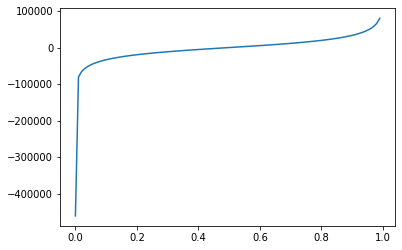

In [284]:
A_sum, A_diff = generate_A()

T = np.random.rand() * 3000 
Tm_1 = np.random.rand() * 3000 
Tm_2 = np.random.rand() * 3000 
print(T, Tm_1, Tm_2)

TM = (Tm_1 + Tm_2)/2
print(TM)

A_1, A_2 = A(A_sum, A_diff, TM)
print(A_1, A_2)

f = func(x, T, A_1, Tm_1, Tm_2, 0, 0)
plt.plot(x.detach(), f.detach())
plt.show()
f_ = first_derivative(x, T, A_1, Tm_1, Tm_2, 0, 0)
plt.plot(x.detach(), f_.detach())

In [26]:
dn = DerivativeNet(train=True)

In [27]:
f_ = grad(f, x, torch.ones_like(x))[0]

In [28]:
optimizer = torch.optim.Adam(dn.parameters(), lr=.5e-2)

f_c = torch.clone(f).detach()

for i in range(100):
    out = dn(f_c)
    
    optimizer.zero_grad()
    loss = nn.MSELoss()(out, f_)
    loss.backward()
    print(loss)
    optimizer.step()

tensor(281.5853, grad_fn=<MseLossBackward0>)
tensor(273.8296, grad_fn=<MseLossBackward0>)
tensor(266.6855, grad_fn=<MseLossBackward0>)
tensor(259.2386, grad_fn=<MseLossBackward0>)
tensor(251.5174, grad_fn=<MseLossBackward0>)
tensor(243.8453, grad_fn=<MseLossBackward0>)
tensor(236.3557, grad_fn=<MseLossBackward0>)
tensor(229.3036, grad_fn=<MseLossBackward0>)
tensor(222.8498, grad_fn=<MseLossBackward0>)
tensor(217.0171, grad_fn=<MseLossBackward0>)
tensor(211.6095, grad_fn=<MseLossBackward0>)
tensor(206.2027, grad_fn=<MseLossBackward0>)
tensor(200.3458, grad_fn=<MseLossBackward0>)
tensor(193.7725, grad_fn=<MseLossBackward0>)
tensor(186.4284, grad_fn=<MseLossBackward0>)
tensor(178.3866, grad_fn=<MseLossBackward0>)
tensor(169.7940, grad_fn=<MseLossBackward0>)
tensor(160.8614, grad_fn=<MseLossBackward0>)
tensor(151.8027, grad_fn=<MseLossBackward0>)
tensor(142.7717, grad_fn=<MseLossBackward0>)
tensor(133.8636, grad_fn=<MseLossBackward0>)
tensor(125.0925, grad_fn=<MseLossBackward0>)
tensor(116

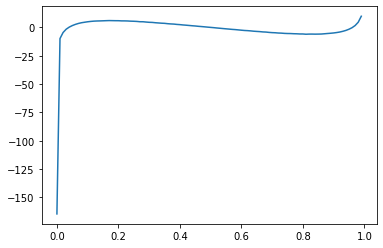

In [29]:
plt.plot(x.detach(), out.detach())